# Deep Learning with OpenCV
**Satya Mallick, LearnOpenCV.com**

# Highlights 
1. Train elsewhere, perform inference in an OpenCV application

2. Supports **Caffe**, **Tensorflow**, **Torch** and **Darknet**.

3. **Supported layers** : AbsVal, AveragePooling, BatchNormalization, Concatenation, Convolution (including dilated convolution), Crop, Deconvolution, DetectionOutput (SSD-specific layer), Dropout, Eltwise (+, *, max), Flatten, FullyConnected, LRN, LSTM, MaxPooling, MaxUnpooling, MVN, NormalizeBBox (SSD-specific layer), Padding, Permute, Power, PReLU (including ChannelPReLU with channel-specific slopes), PriorBox (SSD-specific layer), ReLU, RNN, Scale, Shift, Sigmoid, Slice, Softmax, Split, TanH

# Caffe Model Example : OpenPose 
![OpenPose Dance](openpose-dance.gif)

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import os

# Load a Caffe Model
A typical Caffe Model has two files

1. **Architecture** : Defined in a **.prototxt** file 
2. **Weights** : Defined in **.caffemodel** file

In [2]:
if not os.path.isdir('model'):
  os.mkdir("model")    

protoFile = "model/mpi.prototxt"
weightsFile = "model/mpi.caffemodel"

if not os.path.isfile(protoFile):
  # Download the proto file
  !wget https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt -O $protoFile

if not os.path.isfile(weightsFile):
  # Download the model file
  !wget http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel -O $weightsFile

In [3]:
nPoints = 15
POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Read Image

In [4]:
im = cv2.imread("man.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
inWidth = im.shape[1]
inHeight = im.shape[0]

# Convert image to blob

In [5]:
netInputSize = (368, 368)
inpBlob = cv2.dnn.blobFromImage(im, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False)
net.setInput(inpBlob)

# Run Inference (forward pass)

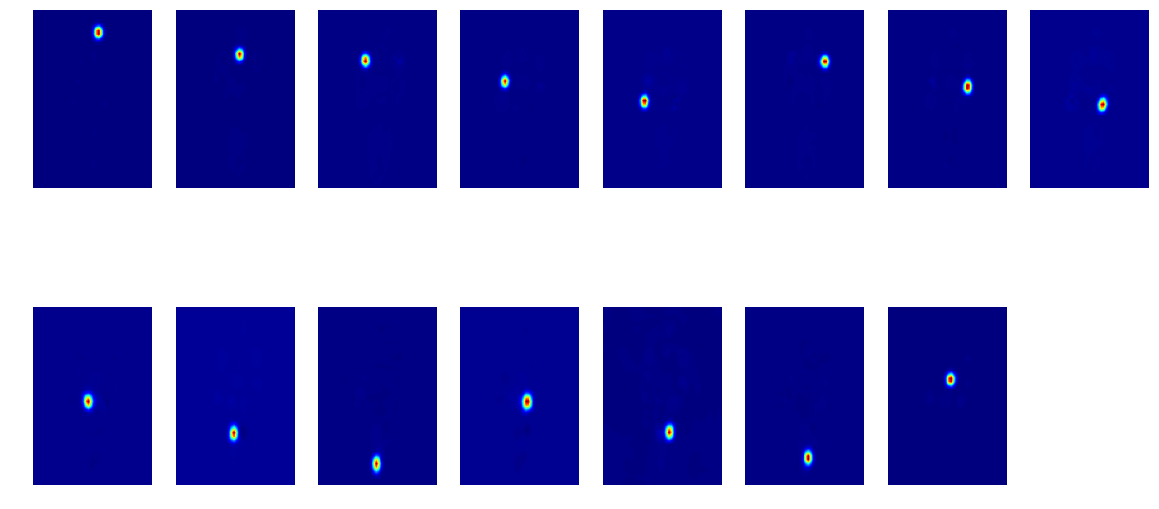

In [6]:
# Forward Pass
output = net.forward()

# Display probability maps
plt.figure(figsize=(20,10))
for i in range(nPoints):
    probMap = output[0, i, :, :]
    displayMap = cv2.resize(probMap, (inWidth, inHeight), cv2.INTER_LINEAR)
    plt.subplot(2, 8, i+1); plt.axis('off'); plt.imshow(displayMap, cmap='jet')

# Extract points

In [7]:
# X and Y Scale
scaleX = inWidth / output.shape[3]
scaleY = inHeight / output.shape[2]

# Empty list to store the detected keypoints
points = []

# Treshold 
threshold = 0.1

for i in range(nPoints):
    # Obtain probability map
    probMap = output[0, i, :, :]
    
    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = scaleX * point[0]
    y = scaleY * point[1]

    if prob > threshold : 
        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)


# Display Points & Skeleton

In [8]:
imPoints = im.copy()
imSkeleton = im.copy()
# Draw points
for i, p in enumerate(points):
    cv2.circle(imPoints, p, 8, (255, 255,0), thickness=-1, lineType=cv2.FILLED)
    cv2.putText(imPoints, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, lineType=cv2.LINE_AA)

# Draw skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(imSkeleton, points[partA], points[partB], (255, 255,0), 2)
        cv2.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)



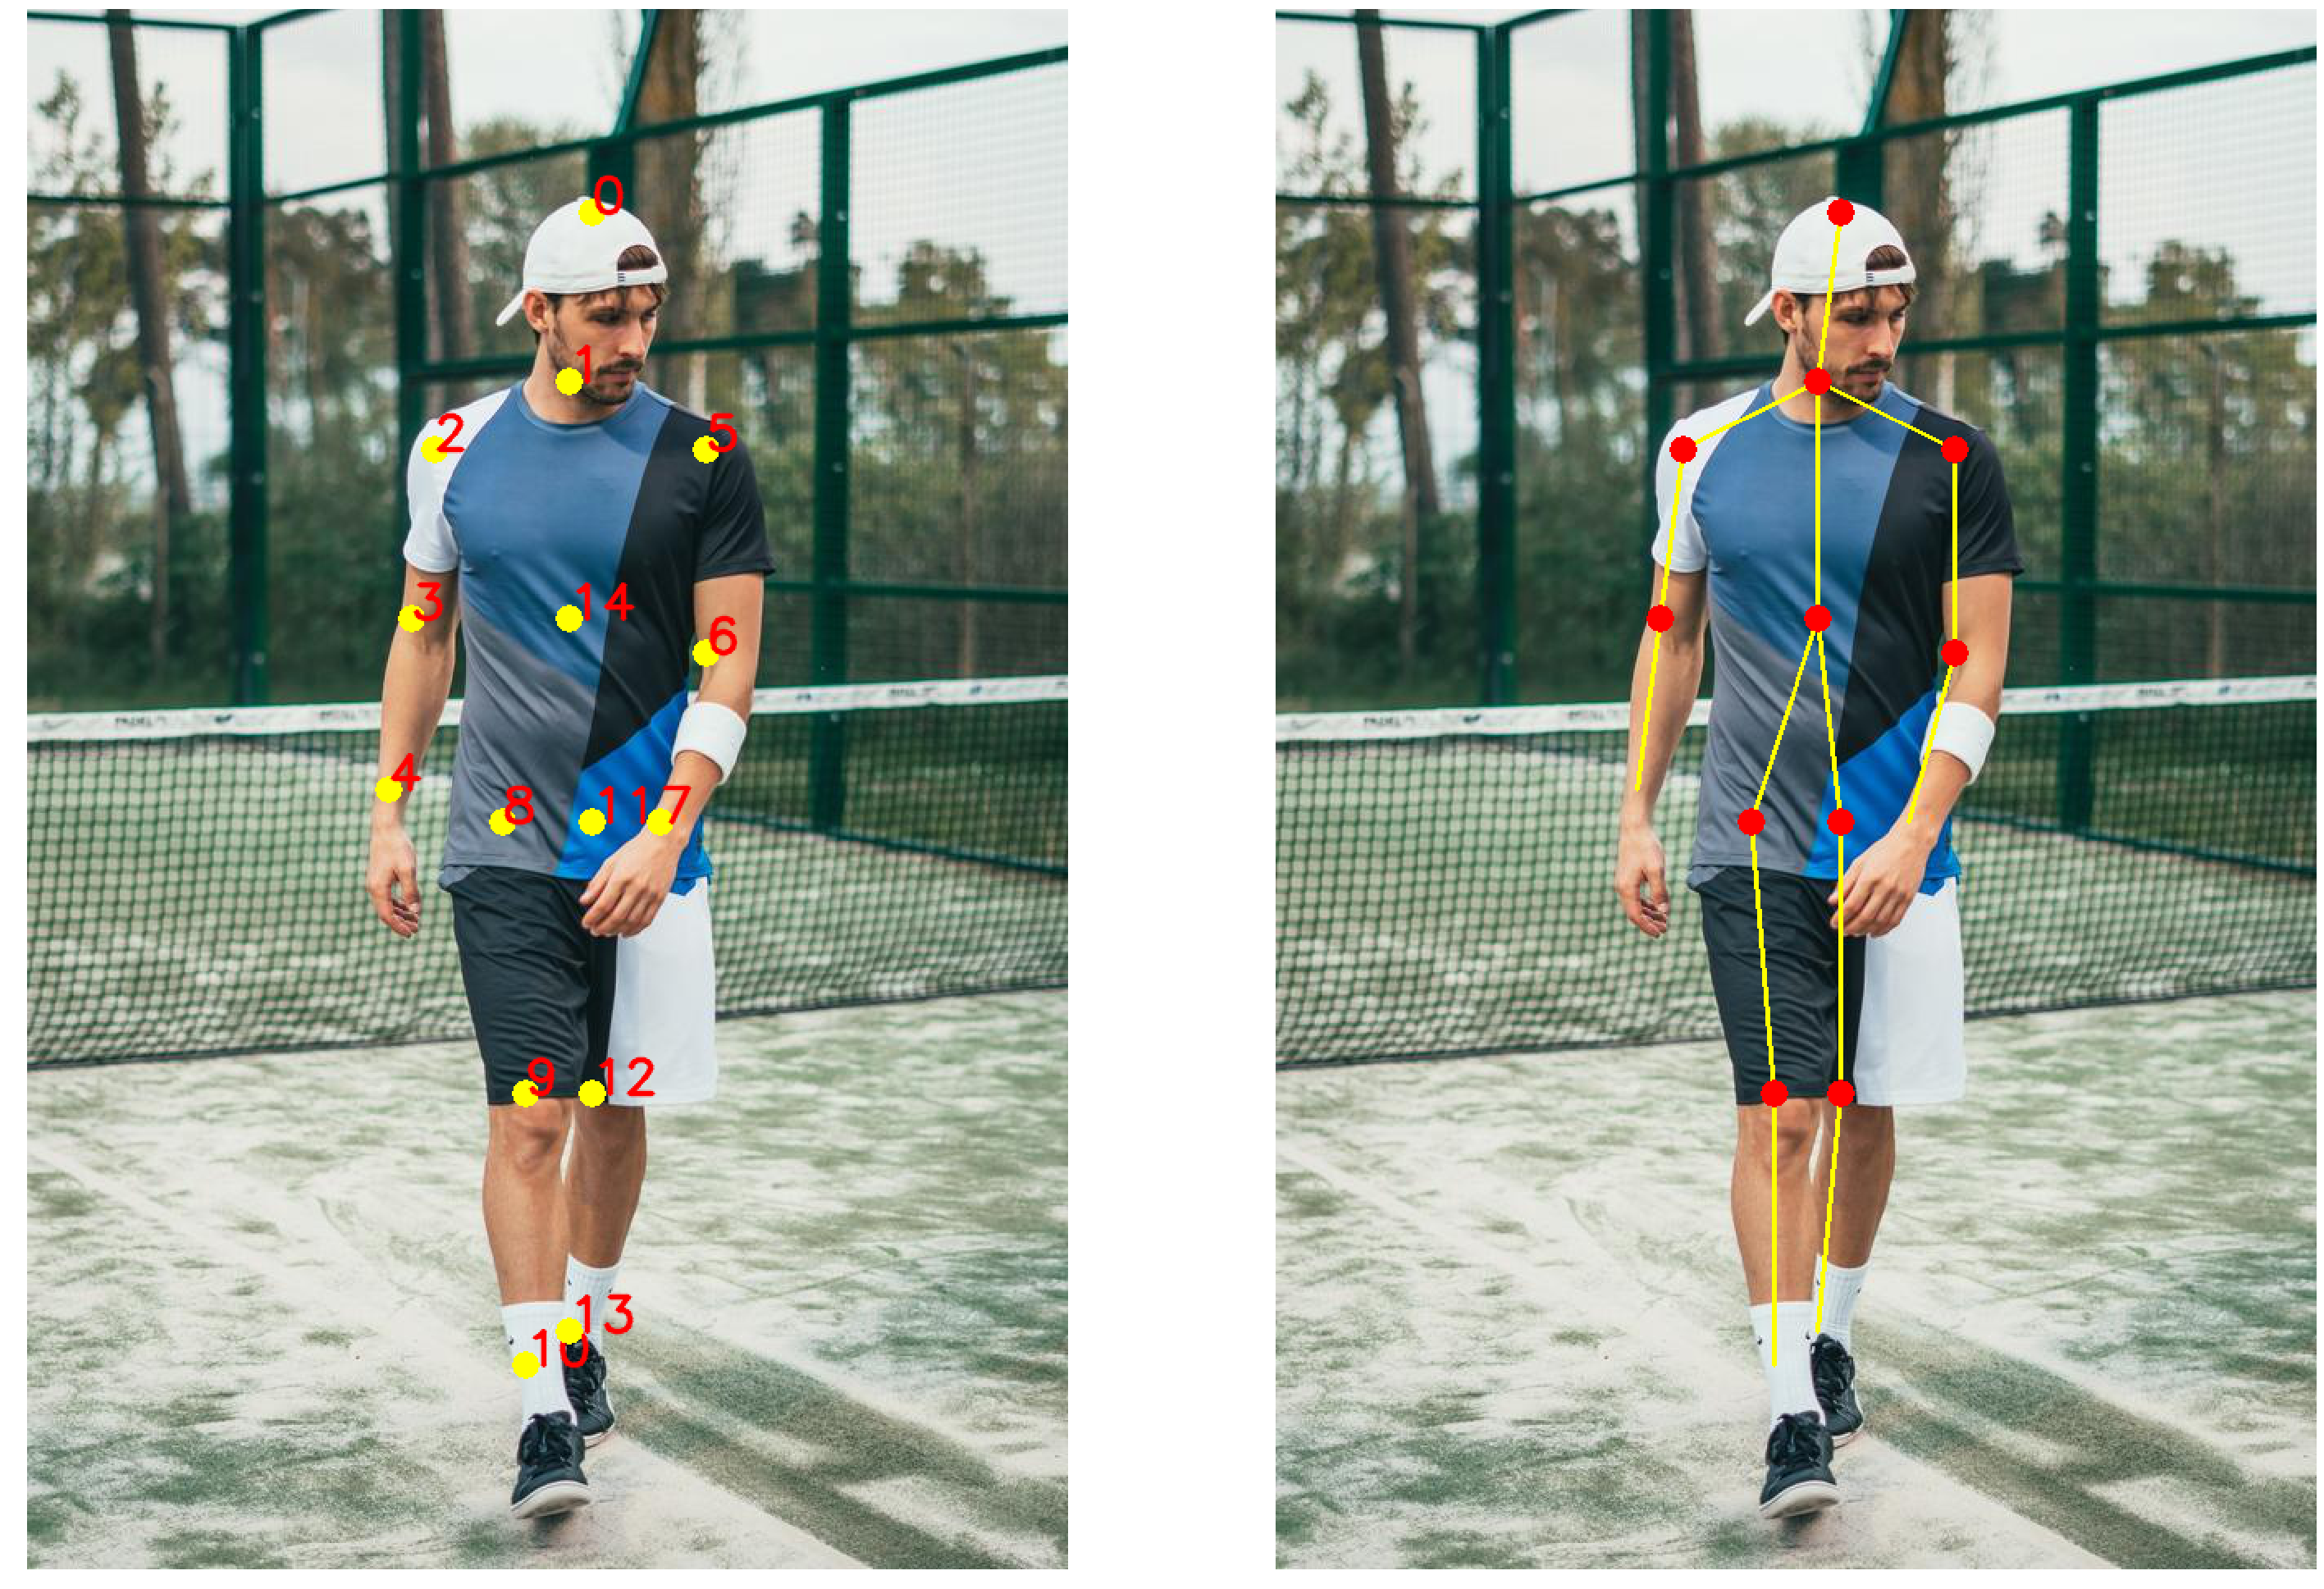

In [9]:
plt.figure(figsize=(50,50))
plt.subplot(121); plt.axis('off'); plt.imshow(imPoints);
plt.subplot(122); plt.axis('off'); plt.imshow(imSkeleton);

# Thank You!